<a href="https://colab.research.google.com/github/hjornskar-ctrl/dim-clem/blob/main/Param_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Moving to a coherent analysis:

    Using the CBC model, build likelihood, prior and posterior functions for the network of gravitational-wave detectors.
    Maximise the likelihood function and plot relevant quantities.
    Interface the posterior function with a sampling algorithm.
        You are free to select any ready-made algorithm, or write your own. (will just use MCMC)
    Perform the sampling, and plot the results.
        This step can take a long time, and so it is best to develop and test first with a few sampling iterations, and not with the whole sampling run.
    Compare the results with the literature and discuss.


Going to do it with a single detector first

In [1]:
import numpy as np
import matplotlib.pyplo t as plt

In [2]:
! pip install -q gwpy

In [3]:
! pip install -q lalsuite pycbc

In [4]:
from gwpy.timeseries import TimeSeries

/usr/local/lib/python3.11/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [5]:
from gwosc.datasets import event_gps

GW200129_065458

In [6]:
time_centre = event_gps('GW200129_065458')

print(time_centre)

1264316116.4


In [7]:
data={} # an empty dictionary
ifos=['L1','H1'] # a list which we use as the dictionary keys
for ifo in ['H1','L1']:
    data[ifo] = TimeSeries.fetch_open_data(ifo, time_centre - 16, time_centre +16)

In [8]:
# Remove the low frequency content and downsample the data to 2048Hz
for ifo in ['H1','L1']:
    data[ifo] = data[ifo].highpass(15).resample(2048)

GOing to down sample for speed. In the paper, for CBC model parameter estimation, the sampling rate was also down sampled from 4096 Hz to 2048 Hz.

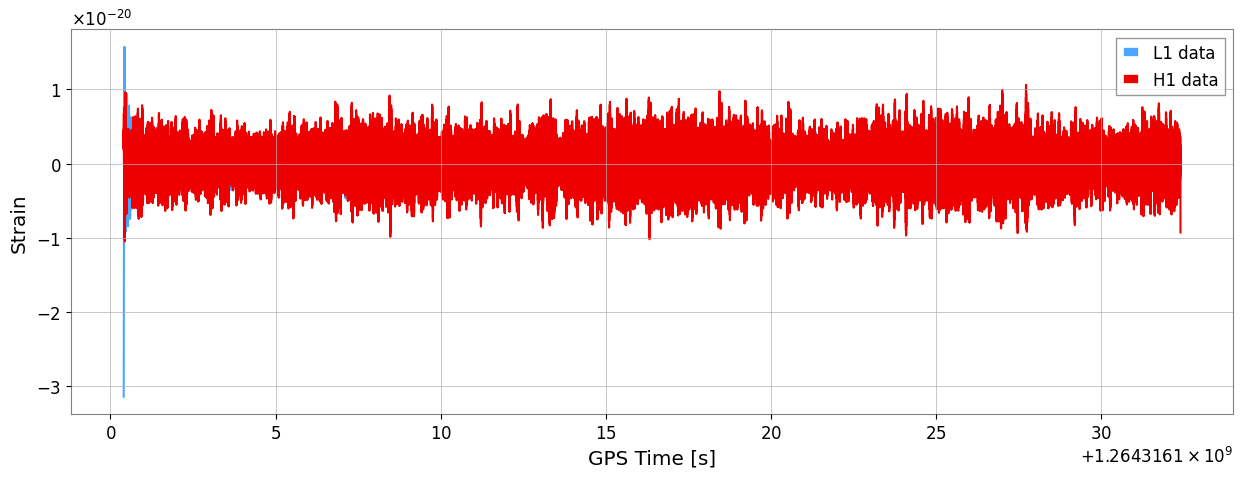

In [9]:
plt.figure(figsize=(15,5))
colours=['gwpy:ligo-livingston','gwpy:ligo-hanford']
for ifo,colour in zip(ifos,colours):
    plt.plot(data[ifo],label='{} data'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();

The waveforms seem fairly similar, with the glitch in L1 as described in the paper being fairly obvious.

I'm not sure what to do about this...

The excess power from the glitch directly overlapping GW200129 in LIGO Livingston was subtracted before estimation of the signal’s source properties [1, 5] using the gwsubtract algorithm: https://arxiv.org/abs/1809.05348

In [10]:
psd={}
for ifo in ifos:
    psd[ifo] = data[ifo].psd(fftlength=4)

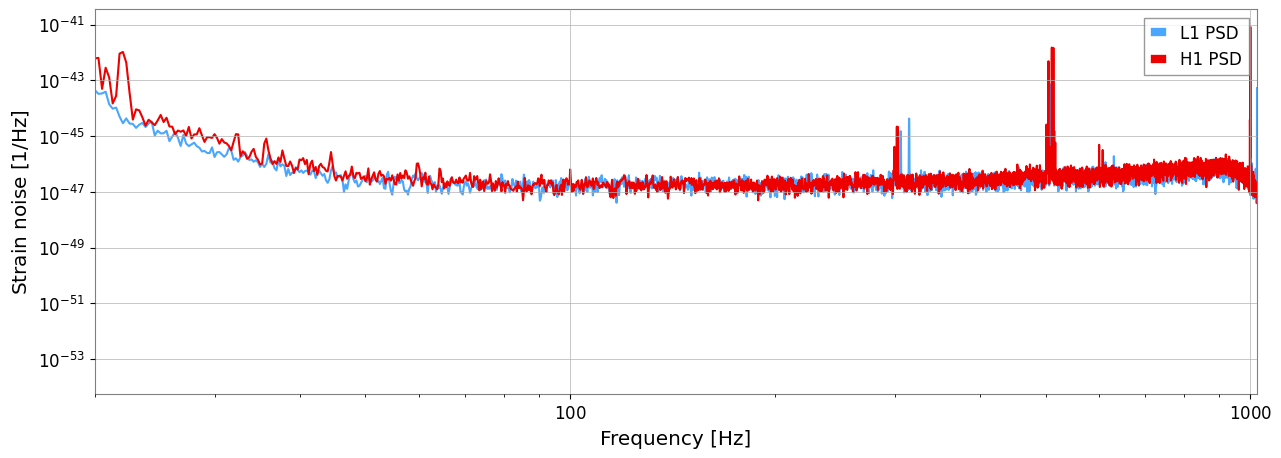

In [11]:

plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
    plt.loglog(psd[ifo],label='{} PSD'.format(ifo),color=colour)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.xlim(20,1024)
plt.legend();

In [12]:
from pycbc.waveform import get_td_waveform

Waveform systematics are expected to play a significant role in GW200129’s inference (e.g. Refs. [1, 14, 101]), which motivates utilizing NRSur7dq4 for all of our main text results.

It does not work :(

In [13]:
from pycbc.waveform import td_approximants, fd_approximants

print(td_approximants())

['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'IMRPhenomTP', 'IMRPhenomTPHM', 'SEOBNRv4HM_PA', 'pSEOBNRv4HM_PA', 'IMRPhenomXAS_NRTidalv2', 'IMRPhenomXP_NRTidalv2', 'IMRPhenomXO4a', 'E

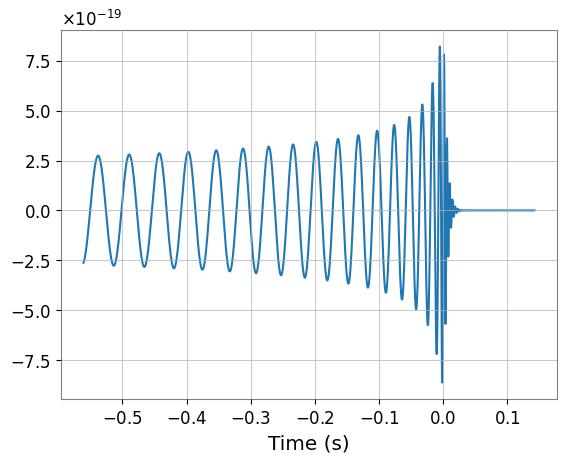

In [14]:
m1 = 34.5 * (1 + 0.18)
m2 = 29 * (1 + 0.18)
hp, hc = get_td_waveform(approximant='SEOBNRv4_opt',
                          mass1=m1,
                          mass2=m2,
                          delta_t=data['H1'].dt.value,
                          f_lower=20)
plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)');

With two detectors we are potentially sensitive to more than a single polarization of gravitational
waves. We also have to account for the delay in the time of arrival of the signal based on where in
the sky the source may be located. This expands our parameters to be component mass (assuming
an equal mass binary), right ascension, declination, luminosity distance, inclination, merger time,
merger phase, and polarization angle.
For a give set of parameters⃗ 𝜆 we’ll now have to generate the plus and cross polarizations of the GW
emission (taking into account the inclination of the binary, and scaling to the proper distance), then
combine these with each detector’s antenna pattern (which depend on the location of the binary
relative to the detector’s orientation) to determine the detector response. Finally, we have to shift
the time of arrival of the signal to be consistent with the delay time expected based on the RA and
dec of the binary.

In [15]:
from pycbc.detector import Detector

In [16]:
# Creating the detector objects:
det={}
for ifo in ifos:
    det[ifo]=Detector(ifo)

In [17]:
declination = 0
right_ascension = 5.5
polarization = 0.0 # uniform prior
fp={}
fc={}
for ifo in ifos:
    fp[ifo], fc[ifo] = det[ifo].antenna_pattern(right_ascension, declination,polarization, time_centre)
    print("{}: fp={}, fc={}".format(ifo,fp[ifo], fc[ifo]))

L1: fp=0.6744893702502468, fc=0.5331967726439342
H1: fp=-0.43843192801721637, fc=-0.5440881149926894


In [18]:
ht={}
for ifo in ifos:
    ht[ifo] = fp[ifo] * hp + fc[ifo] * hc

With the antenna beam pattern functions we can then compute the gravitational-wave signal as
seen by each detector:

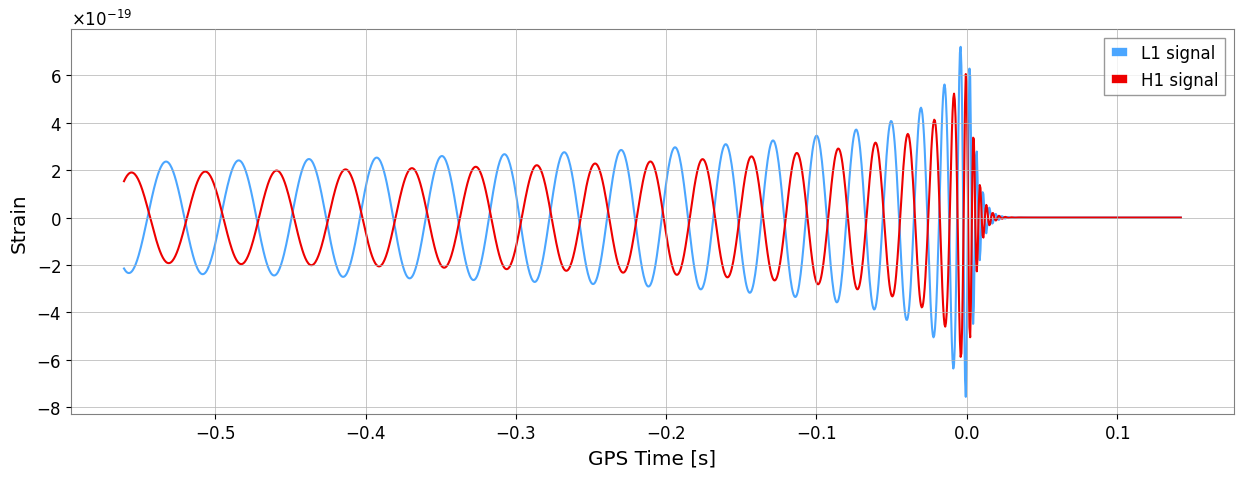

In [19]:
plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
    plt.plot(TimeSeries.from_pycbc(ht[ifo]),label='{} signal'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend()

'The rate of glitches at frequencies similar to the signal is much lower; using data from 4 days around the event, the rate of glitches with frequency 60-120 Hz is only 0.06/hr.'

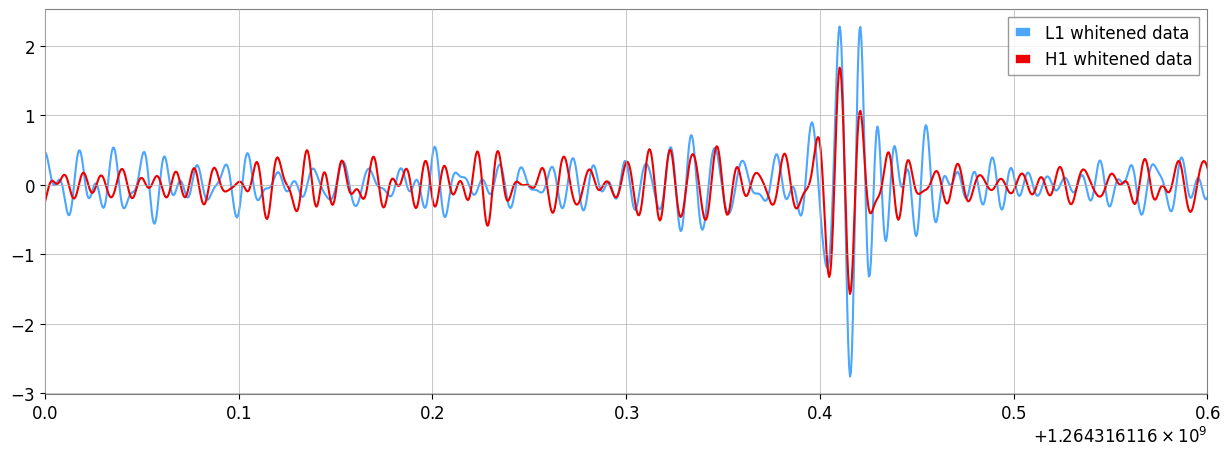

In [20]:
plt.figure(figsize=(15,5))
white_data={}
for ifo,colour in zip(ifos,colours):
    white_data[ifo]=data[ifo].whiten(fftlength=4).bandpass(60,120)
    plt.plot(white_data[ifo],label='{} whitened data'.format(ifo),color=colour)
#plt.xlim(time_centre-4, time_centre+5.3)
plt.xlim(time_centre-0.4, time_centre+0.2)
plt.legend()

In [21]:
time_delay=det['H1'].time_delay_from_earth_center(right_ascension, declination,time_centre)
print("For the sky-position ra={},dec={}, at time={},".format(right_ascension,declination,time_centre))
print("the time delay between Hanford and geocenter is {} seconds".format(time_delay))

For the sky-position ra=5.5,dec=0, at time=1264316116.4,
the time delay between Hanford and geocenter is 0.013537617427967502 seconds


As in chapter 7, we’ll make a light-weight wrapper for get_td_waveform() that will take parameter
vector⃗ 𝜆 and generate a waveform for us with the same sampling rate and time window as our data.
However, this time we need to project the “plus” and “cross” polarisations onto the detector arms

In [22]:
for ifo in ifos:
    data[ifo]=data[ifo].crop(time_centre-2,time_centre+2)

In [23]:
def gen_template(param,
    delta_t=data['H1'].dt.value, # Assuming all IFOs have the same dt
    duration=data['H1'].duration.value, # Assuming all IFOs have the same duration !
    start_time=data['H1'].x0.value,# Assuming all IFOs have the same start time !
    f_lower=20.):
    m1, m2, distance, time, phase, right_ascension, declination, inclination,polarization = param

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                            mass1=m1,
                            mass2=m2,
                            distance=distance,
                            inclination=inclination,
                            coa_phase=phase,
                            delta_t=delta_t,
                            f_lower=f_lower)
  # Resize the signal buffer
    hp.resize(int(duration/delta_t))
    hc.resize(int(duration/delta_t))
    ht={}
    template={}
# compute the detectors responses and shift to the requested time
    for ifo in ifos:
        fp, fc = det[ifo].antenna_pattern(right_ascension, declination,polarization, time)
        ht[ifo] = fp * hp.copy() + fc * hc.copy()
        time_delay = det[ifo].time_delay_from_earth_center(right_ascension,declination, time)
        ht[ifo] = ht[ifo].cyclic_time_shift(ht[ifo].start_time + time - start_time + time_delay)
        ht[ifo].start_time=start_time
        template[ifo]=TimeSeries.from_pycbc(ht[ifo])
    return template

(1264316116.2, 1264316116.45)

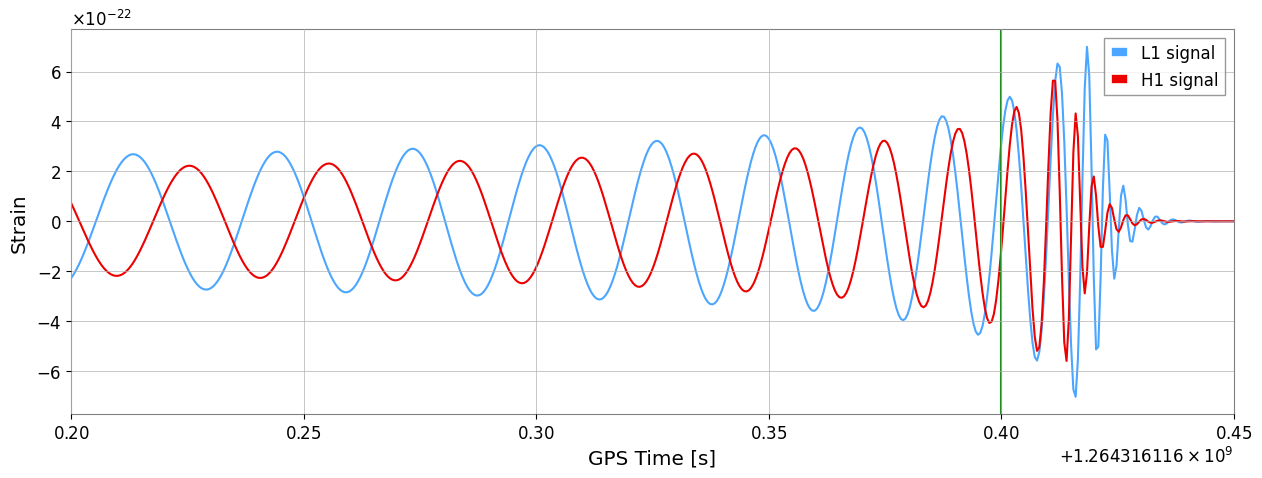

In [24]:
# Testing the gen_template() function:
param=[34.5,29,890,1264316116.4,0.0,5.5, 0, 0, 0.]
# m1, m2, distance, time, phase, right_ascension, declination, inclination,polarization = param
template=gen_template(param)
plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
  plt.plot(template[ifo],label='{} signal'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();
plt.axvline(time_centre,c='forestgreen')
plt.xlim([time_centre-0.2,time_centre+0.05])

With the network waveform generator now defined, we can define our likelihood function, which is
equivalent to the product of single-detector likelihood functions

To construct a likelihood function for the GW detector network (the two LIGO instruments in this
case), we will make the very reasonable assumption that noise is independent between detectors.
This means that our network likelihood fuction is just the product of single-detector likelihood
functions

In [25]:
# FFT the data once, ahead of time
sf={}
for ifo in ifos:
    sf[ifo] = data[ifo].average_fft(window=('tukey',1./4.))*data[ifo].duration.value/2
def loglikelihood(param, sf=sf, f_lower=20.0):
    hf_hp = {}

    logl=0.0

    template = gen_template(param, delta_t=data['H1'].dt.value ,f_lower=f_lower)

    for ifo in ifos:
        # zero out the frequencies below f_lower
        sf_hp = sf[ifo].crop(start=f_lower)
        psd_hp = psd[ifo].crop(start=f_lower)

        hf = template[ifo].average_fft(window=('tukey',1./4.))*template[ifo].duration.value/2
        hf_hp = hf.crop(start=f_lower)

        h_dot_h = 4 * np.real((hf_hp * hf_hp.conjugate() / psd_hp).sum() *hf_hp.df)
        h_dot_s = 4 * np.real((sf_hp * hf_hp.conjugate() / psd_hp).sum() *sf_hp.df)

        logl += h_dot_s - h_dot_h/2
    return logl.value

-1162.2993619676254


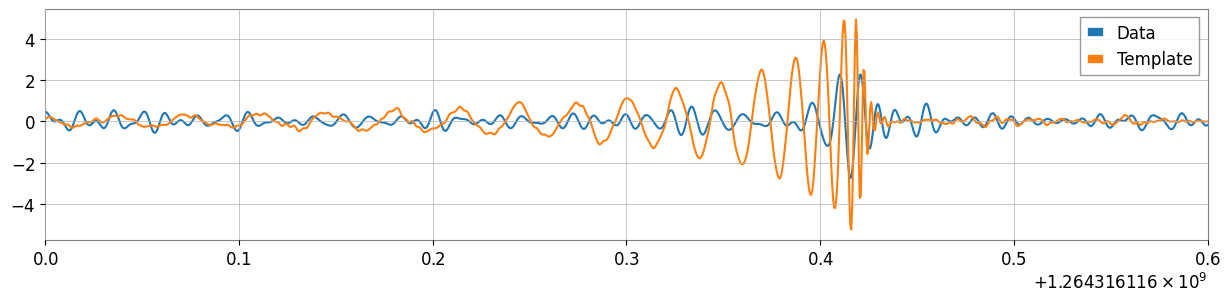

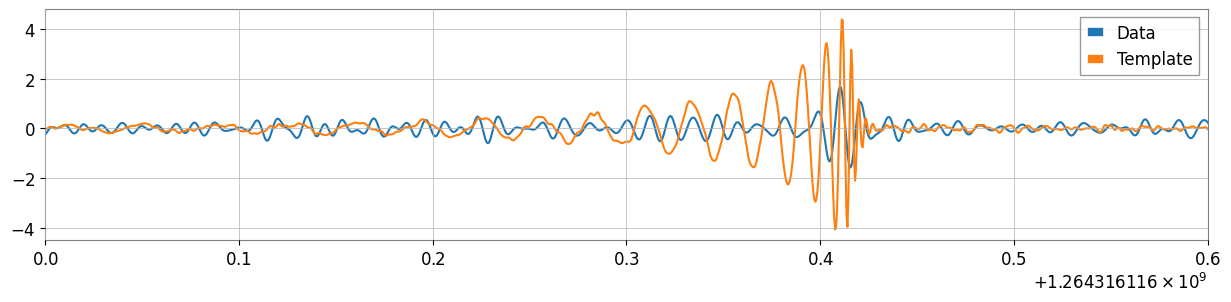

In [26]:
param0=[34.5,29,890,1264316116.4,0.0,5.5, 0, 0, 0.]

template0 = gen_template(param0)

for ifo in ifos:
    white_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    plt.figure(figsize=[15, 3])
    plt.plot(white_data[ifo].times, white_data[ifo], label="Data")
    plt.plot(white_template.times, white_template, label="Template")
    plt.xlim(time_centre-0.4, time_centre+0.2)
    plt.legend();

print(loglikelihood(param0))

Now let’s maximize the likelihood to find the best-fit signal. We’ll use the minimize() function
provided by scipy using the Powell method, since it’s pretty good at dealing with non-smooth
functions. We’ll also define a callback function to print likelihood values and plot the model as it
works.

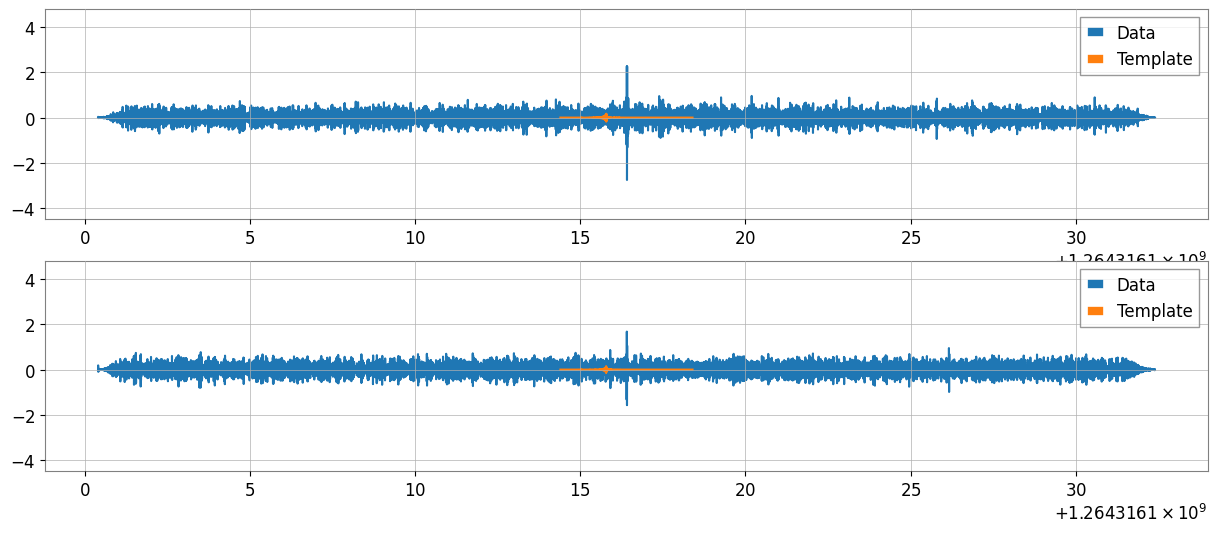

Steps	log(likelihood)
18	4.881


In [29]:
from scipy.optimize import minimize
from IPython.display import display, clear_output
fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1
lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)
    ax.plot(white_data[ifo].times, white_data[ifo], label="Data")

    lines[ifo], = ax.plot(white_template.times, white_template,label="Template")

    #ax.set_xlim(time_centre-.2, time_centre+.05)
    ax.legend()


def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:

        white_template = template[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)

    display(fig)

    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(param_i)))

    Neval += 1


res = minimize(lambda param: -loglikelihood(param), param0, callback=callback,method='powell')
plt.close()

In [ ]:
from scipy.optimize import minimize
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np

# Define time window around `time_centre` to display
xlim_window = (-0.2, 0.05)  # You can change this once and it applies everywhere

fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1
lines = {}

for ax, ifo in zip(axs, ifos):
    white_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]), highpass=20.)
    ax.plot(white_data[ifo].times, white_data[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")

    # Set x-axis limits dynamically
    ax.set_xlim(time_centre + xlim_window[0], time_centre + xlim_window[1])
    ax.legend()

def callback(param_i):
    global Neval
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd[ifo]), highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)

    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(param_i)))

    Neval += 1

res = minimize(lambda param: -loglikelihood(param), param0, callback=callback, method='powell')
plt.close()
